In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#Load the dataset
data=pd.read_csv("california_housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [3]:
#Check missing values
missing_values=data.isnull().sum()
missing_values

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [4]:
duplicated_values=data.duplicated().sum()
duplicated_values

0

In [5]:
#Check for empty values
empty_values=data.empty
empty_values

False

In [6]:
#Normalize/Standardize numerical features
scaler=StandardScaler()
numerical_features=data.drop(columns=["median_house_value"])
scaled_features=scaler.fit_transform(numerical_features)
scaled_data=pd.DataFrame(scaled_features,columns=numerical_features.columns)
scaled_data["median_house_value"]=data["median_house_value"].values

In [7]:
#Split the dataset into training and test data sets
X=scaled_data.drop(columns="median_house_value")
y=scaled_data["median_house_value"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((13600, 8), (3400, 8), (13600,), (3400,))

Explotatory Data Analysis (EDA)

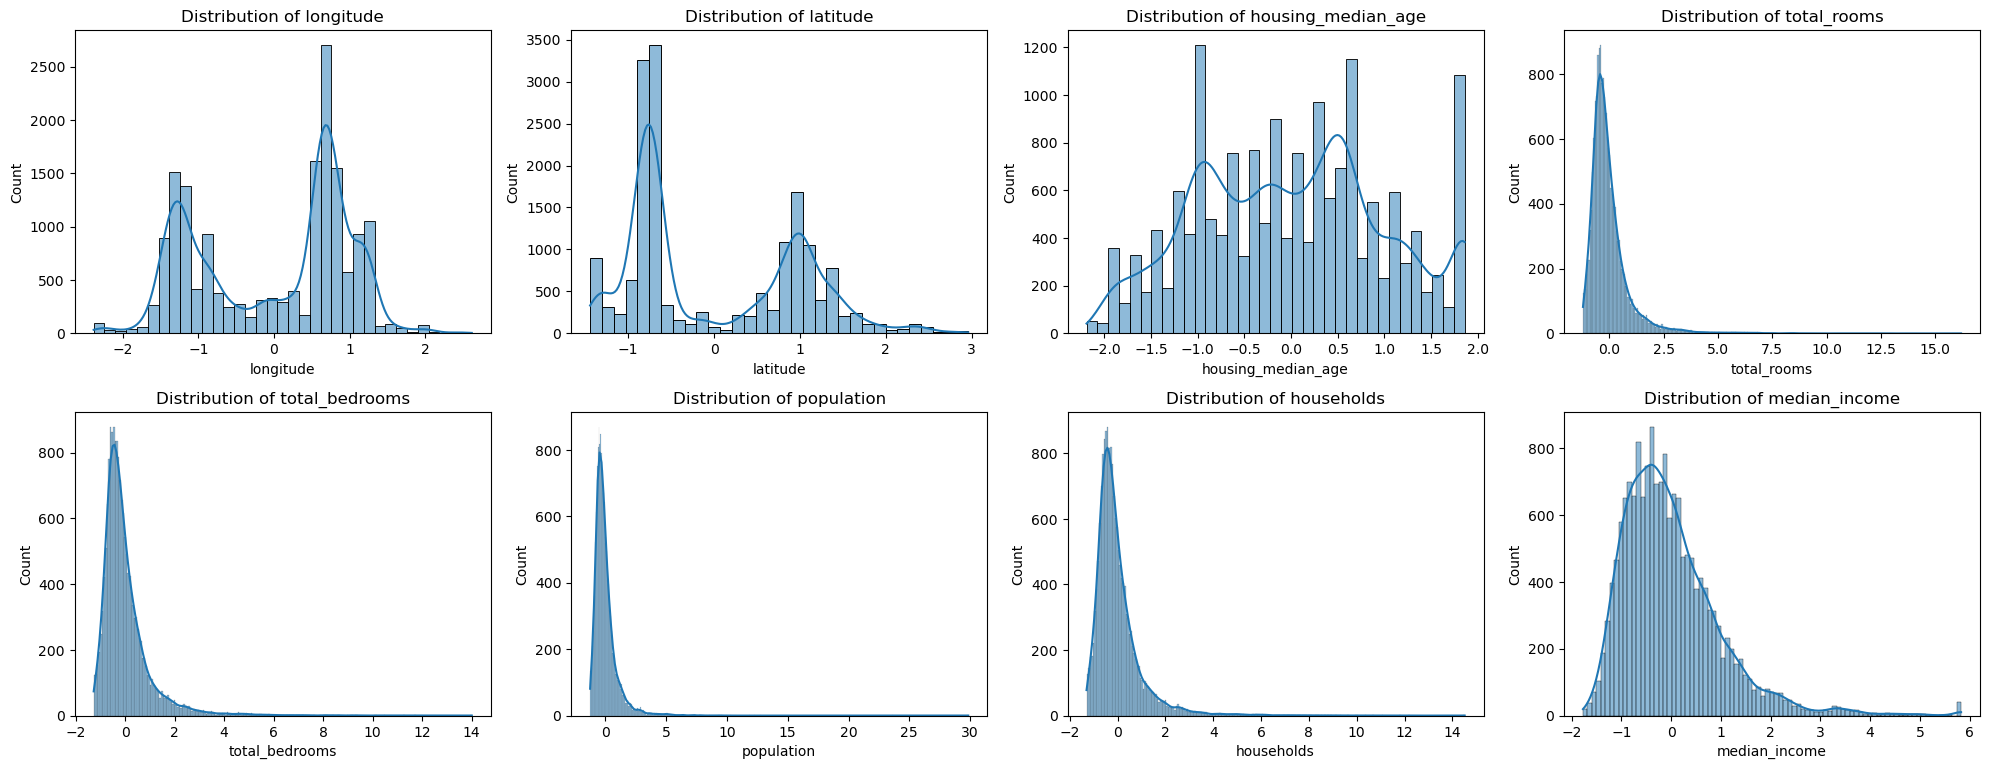

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

#Analyse the distribution of each features
plt.figure(figsize=(20,15))
for i, col in enumerate(X.columns,1):
    plt.subplot(4,4,i)
    sns.histplot(X[col],kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

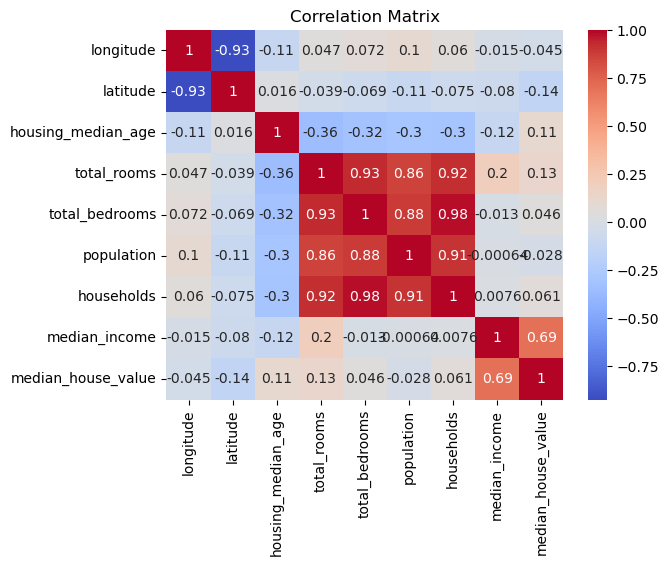

In [9]:
#Analyze the correlation between the features and the target variables
correlation_matrix=scaled_data.corr()
sns.heatmap(correlation_matrix,annot=True,cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

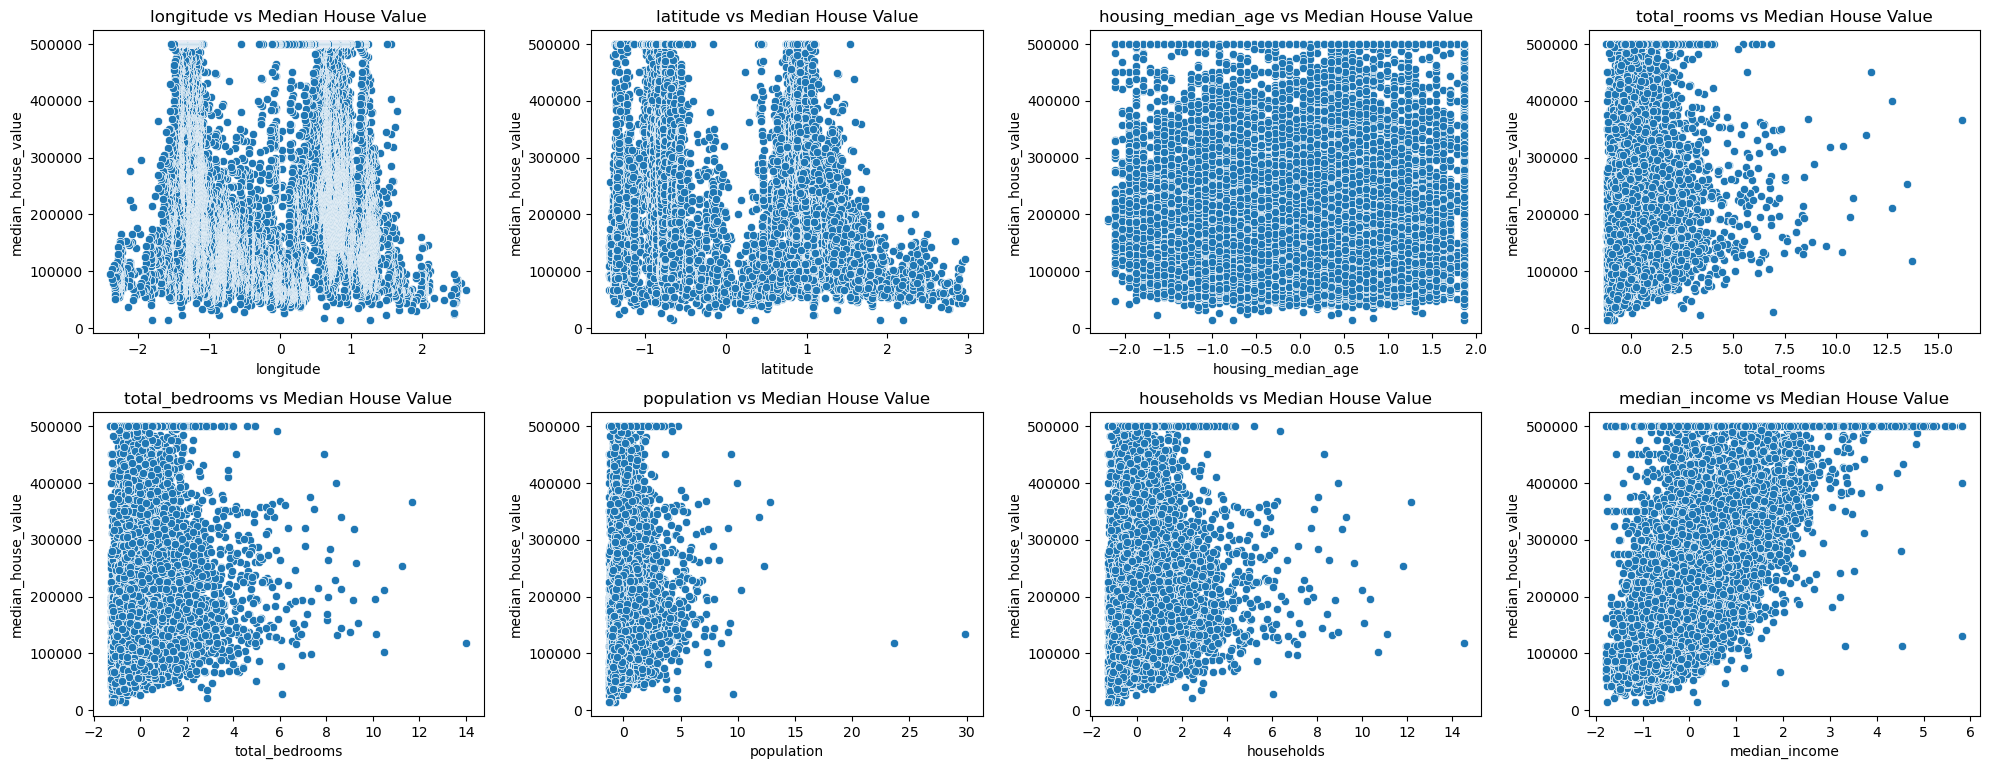

In [10]:
#Visualize the relationships using scatter plots
plt.figure(figsize=(20,15))
for i, col in enumerate(X.columns,1):
    plt.subplot(4,4,i)
    sns.scatterplot(x=scaled_data[col],y=scaled_data["median_house_value"])
    plt.title(f"{col} vs Median House Value")
plt.tight_layout()
plt.show()

Machine Learning Model Development

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [12]:
lr=LinearRegression()
rf=RandomForestRegressor(random_state=42)
gb=GradientBoostingRegressor(random_state=42)

In [14]:
#Train the model
models={"LinearRegression":lr,"Random Forest":rf,"Gradient Boosting":gb}
results={}

In [15]:
for model_name, model in models.items():
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    rmse=root_mean_squared_error(y_test,y_pred)
    mae=mean_absolute_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    results[model_name]={"RMSE":rmse,"MAE":mae,"R2":r2}

results

{'LinearRegression': {'RMSE': 68078.32552452621,
  'MAE': 49983.474651229204,
  'R2': 0.6636396350243802},
 'Random Forest': {'RMSE': 49456.69323991812,
  'MAE': 32399.400661764706,
  'R2': 0.8224841095241663},
 'Gradient Boosting': {'RMSE': 54436.56420422008,
  'MAE': 37586.528167677316,
  'R2': 0.7849356142516728}}

Model Deployment and Recommendation

In [16]:
import pickle

#Select the best performing model
best_model=gb

#Save the trained model to the file
with open("best_model.pkl","wb") as file:
    pickle.dump(best_model,file)

#Load the saved model
with open("best_model.pkl","rb") as file:
    loaded_model=pickle.load(file)

#Make predictions using loaded model
y_pred=loaded_model.predict(X_test)

#Evaluate the model's performance
rmse=root_mean_squared_error(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print("Model Performance")
print("RMSE:",rmse)
print("MAE:",mae)
print("R2 Score:",r2)

Model Performance
RMSE: 54436.56420422008
MAE: 37586.528167677316
R2 Score: 0.7849356142516728


In [18]:
#Example usage of the deployed model
new_data=pd.DataFrame({
    "latitude":[37.7749],
    "longitude":[-122.4194],
    "housing_median_age":[30],
    "total_rooms":[2000],
    "total_bedrooms":[400],
    "population":[1000],
    "households":[400],
    "median_income":[5.0]
})

#Set the feature names of new_data to match the feature names used during training
new_data.columns=X.columns

#Scale the new data using the same scaler used during training
new_data_scaled=scaler.transform(new_data)

#Make predictions on new data
new_predictions=loaded_model.predict(new_data_scaled)
print("Predictions for new data:",new_predictions)

Predictions for new data: [154813.07354931]


C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [19]:
#Save the model to the file
with open ("gradient_boosting_model.pkl","wb") as f:
    pickle.dump(gb,f)

In [21]:
from flask import Flask, request
import numpy as np

app=Flask(__name__)

#Load the model from the file
with open("gradient_boosting_model.pkl","rb") as f:
    model=pickle.load(f)

@app.route("/predict", methods=["POST"])
def predict():
    #Get the input data from the request
    data=request.get_json()
    input_data=np.array(data["input"]).reshape(1,-1)

    #Make prediction using the model
    prediction=model.predict(input_data)

    #Return the prediction as a JSON response
    return {"prediction": prediction.tolist()}

if __name__=="__main__":
    app.run(port=5003)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5003
Press CTRL+C to quit
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
127.0.0.1 - - [24/Jun/2024 14:38:15] "POST /predict HTTP/1.1" 200 -
